In [1]:
from pathlib import Path
from shapely import Polygon, Point, box, MultiPoint
import geopandas as gpd
from geopandas import GeoDataFrame
import gtfs_kit as gk
from gtfs_kit import restrict_to_area
from dataclasses import dataclass
import pickle
import numpy as np
from r5py import TravelTimeMatrixComputer, TransportMode, TransportNetwork
from datetime import timedelta
import contextily as cx
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd

In [2]:
osm_pf= Path('data/australia-latest.osm.pbf')
# gtfs_pf = Path('data/google_transit.zip')
base_crs = "EPSG:4326"
WGS84_POLY = Polygon.from_bounds(xmin=-180.0, ymin=-90.0, xmax=180.0, ymax=90.0)
@dataclass()
class BBOX:
    lower: Point
    upper: Point
    def validate_bbox(self):
        for p in [self.lower, self.upper]:
            assert p.within(WGS84_POLY)
    @property
    def osmconvert(self) -> str:
        offset = 0.001 # to make sure that OSM size > gtfs size add a small offset
        return ','.join(str(x) for x in [self.lower.x-offset,self.lower.y-offset,self.upper.x+offset,self.upper.y+offset])
    @property
    def poly(self) -> box:
        return box(xmin=self.lower.x,ymin=self.lower.y,xmax=self.upper.x,ymax=self.upper.y)
    @property
    def geoframe(self):
        return gpd.GeoDataFrame(index=[0],geometry=[self.poly],crs=base_crs)
        #return gp.GeoDataFrame(geometry=[self.lower,self.upper],crs="EPSG:4326")
#https://epsg.io/map#srs=4326&x=115.679169&y=-32.301063&z=10&layer=streets
bb = BBOX(upper=Point([116.060099,-31.725200]),lower=Point([115.679169,-32.301063]))
bb.validate_bbox()
bb.osmconvert
bb.geoframe
# feed = gk.read_feed(gtfs_pf.__str__(),dist_units='m')
# feed = restrict_to_area(feed=feed,area=bb.geoframe)
# feed.write(Path('data/gtfs_trimmed.zip'))

,geometry
0,"POLYGON ((116.0601 -32.30106, 116.0601 -31.725..."


In [3]:
transport_network = TransportNetwork(osm_pbf='data/cropped.osm.pbf',gtfs=['data/gtfs_trimmed.zip'])
gtfs_pf = Path('data/google_transit.zip')
feed = gk.read_feed(gtfs_pf.__str__(),dist_units='m')


In [54]:
def poly_to_grid_points(bbox:BBOX, spacing:float=0.002) -> GeoDataFrame:
    # faster than two for loops
    pointcoords = np.array(np.meshgrid(
    np.arange(bbox.lower.x, bbox.upper.x, spacing),
    np.arange(bbox.lower.y, bbox.upper.y, spacing))).T.reshape(-1, 2)
    grid=gpd.GeoSeries(gpd.points_from_xy(x=pointcoords[:,0],y=pointcoords[:,1]),crs=base_crs)
    grid.name = 'geometry'
    # origin dataset needs unique "id" column, just make it index
    df = gpd.GeoDataFrame(grid)
    df['id'] = df.index
    return df
pg = poly_to_grid_points(bb,spacing=0.001)
pg['geometry'] = transport_network.snap_to_network(pg['geometry'],radius=100)
pg = pg[~pg['geometry'].is_empty]


In [55]:
pg['index'] = pg.index
stops = feed.get_stops_in_area(area=bb.geoframe)
gstops = gpd.GeoDataFrame(stops,geometry=gpd.points_from_xy(stops.stop_lon,stops.stop_lat),crs=base_crs)
gstops['id'] = stops['stop_id']

In [56]:
base_dir = Path('data/results')
expt_dir = base_dir / 'basecheck'
work_geoframe = gpd.GeoDataFrame(geometry=[Point(115.860234,-31.955612)],crs=base_crs)
work_geoframe['id'] = 0

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
departure_time = datetime(year=2025,month=1,day=13,hour=7)
departure_range = timedelta(hours=1)

tt_matrix = TravelTimeMatrixComputer(transport_network=transport_network,origins=pg,destinations=work_geoframe,transport_modes=[TransportMode.WALK, TransportMode.TRANSIT, TransportMode.BUS, TransportMode.RAIL],
                                     max_time_walking=timedelta(minutes=30),
                                     max_public_transport_rides=10,
                                     breakdown=True,
                                     departure=departure_time,
                                     departure_time_window=departure_range,snap_to_network=False)
tt_matrix_result= tt_matrix.compute_travel_times()

In [57]:
tt_matrix_result

,from_id,to_id,travel_time
0,3490,0,NaN
1,3491,0,NaN
2,4062,0,NaN
3,4063,0,NaN
4,4064,0,NaN
...,...,...,...
93460,219434,0,NaN
93461,219439,0,NaN
93462,219440,0,NaN
93463,219447,0,NaN


,from_id,to_id,travel_time
0,3490,0,NaN
1,3491,0,NaN
2,4062,0,NaN
3,4063,0,NaN
4,4064,0,NaN
...,...,...,...
93460,219434,0,NaN
93461,219439,0,NaN
93462,219440,0,NaN
93463,219447,0,NaN


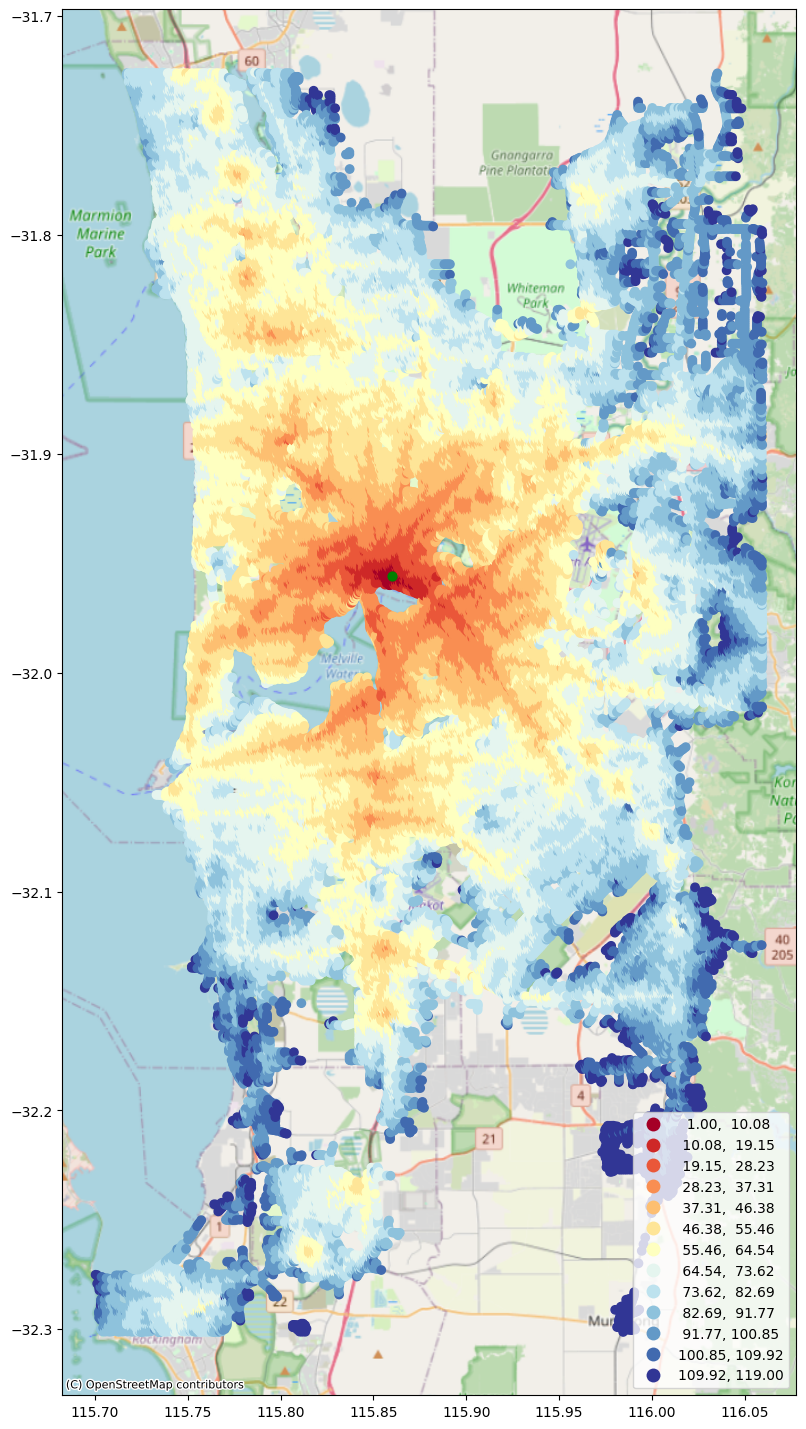

In [58]:
tt_trimmed = tt_matrix_result[tt_matrix_result['travel_time'].notnull()]
geo = pg.merge(tt_trimmed,left_on='id',right_on='from_id')
ax = geo.plot(column="travel_time", cmap="RdYlBu", scheme="equal_interval", k=13, legend=True, figsize=(18,18))
ax = work_geoframe.to_crs(crs=base_crs).plot(ax=ax, color="green", markersize=40)
cx.add_basemap(ax, crs=base_crs,source=cx.providers.OpenStreetMap.Mapnik)
# Save matrixes

if not expt_dir.exists():
    expt_dir.mkdir(parents=True)

with open(expt_dir / 'travel_matrix.pkl', 'wb') as fp:
    pickle.dump(tt_matrix_result,fp)

with open(expt_dir / 'dest_geoframe.pkl', 'wb') as fp:
    pickle.dump(work_geoframe,fp)

with open(expt_dir / 'grid.pkl', 'wb') as fp:
    pickle.dump(pg,fp)
plt.savefig(expt_dir /  'point_test.png')
tt_matrix_result

In [59]:
tt_matrix_result[tt_matrix_result['travel_time'].notnull()]

,from_id,to_id,travel_time
54,12122,0,118.0
57,12694,0,119.0
60,12698,0,114.0
61,13254,0,107.0
62,13256,0,108.0
...,...,...,...
93434,219369,0,109.0
93435,219371,0,105.0
93436,219381,0,117.0
93437,219382,0,115.0


In [60]:
base_dir = Path('data/results')
expt_dir = base_dir / 'basecheck'
with open(expt_dir / 'travel_matrix.pkl', 'rb') as fp:
    tt_matrix_result = pickle.load(fp)

with open(expt_dir / 'dest_geoframe.pkl', 'rb') as fp:
    work_geoframe = pickle.load(fp)

with open(expt_dir / 'grid.pkl', 'rb') as fp:
    pg = pickle.load(fp)

In [61]:
pg2 = pg.merge(tt_matrix_result[tt_matrix_result['travel_time'].notnull()],left_on='id',right_on='from_id',how='inner').merge(work_geoframe,left_on='to_id',right_on='id',how='inner',suffixes=('','_dest'))
pg2

,geometry,id,index,from_id,to_id,travel_time,geometry_dest,id_dest
0,POINT (115.70033 -32.27509),12122,12122,12122,0,118.0,POINT (115.86023 -31.95561),0
1,POINT (115.70119 -32.27913),12694,12694,12694,0,119.0,POINT (115.86023 -31.95561),0
2,POINT (115.70112 -32.27525),12698,12698,12698,0,114.0,POINT (115.86023 -31.95561),0
3,POINT (115.70225 -32.29473),13254,13254,13254,0,107.0,POINT (115.86023 -31.95561),0
4,POINT (115.70217 -32.29306),13256,13256,13256,0,108.0,POINT (115.86023 -31.95561),0
...,...,...,...,...,...,...,...,...
82445,POINT (116.05868 -31.81215),219369,219369,219369,0,109.0,POINT (115.86023 -31.95561),0
82446,POINT (116.05914 -31.81035),219371,219371,219371,0,105.0,POINT (115.86023 -31.95561),0
82447,POINT (116.05937 -31.79968),219381,219381,219381,0,117.0,POINT (115.86023 -31.95561),0
82448,POINT (116.05896 -31.79897),219382,219382,219382,0,115.0,POINT (115.86023 -31.95561),0


In [72]:
from shapely import convex_hull, concave_hull
from shapely.geometry import MultiPoint


def generate_isochrone(pg2):
    isochrones = {}
    # Generate isochrones
    for step in range(15,90,5):
        points = MultiPoint(pg2[pg2['travel_time'] < step]['geometry'].values)
        isochrones[step] = concave_hull(points,ratio=0.02,allow_holes=True)
    
    # Generate dataframe, reindex from 0 for join
    df = pd.DataFrame.from_dict(isochrones, orient="index", columns=["geometry"])
    gdf = gpd.GeoDataFrame(df, geometry=df.geometry, crs=base_crs)
    gdf['time'] = gdf.index
    gdf = gdf.reset_index()
#gdf['time_range'] = gdf.index
    return gdf

gdf = generate_isochrone(pg2)
import matplotlib.pyplot as plt
cmap = plt.get_cmap('plasma_r',len(gdf))
# inferno is black to yellow, we want the opposite
colours = cmap(np.linspace(0,1,len(gdf)))
colours = pd.DataFrame(data=colours,columns=['r','g','b','a'])

gdf = gdf.join(colours)

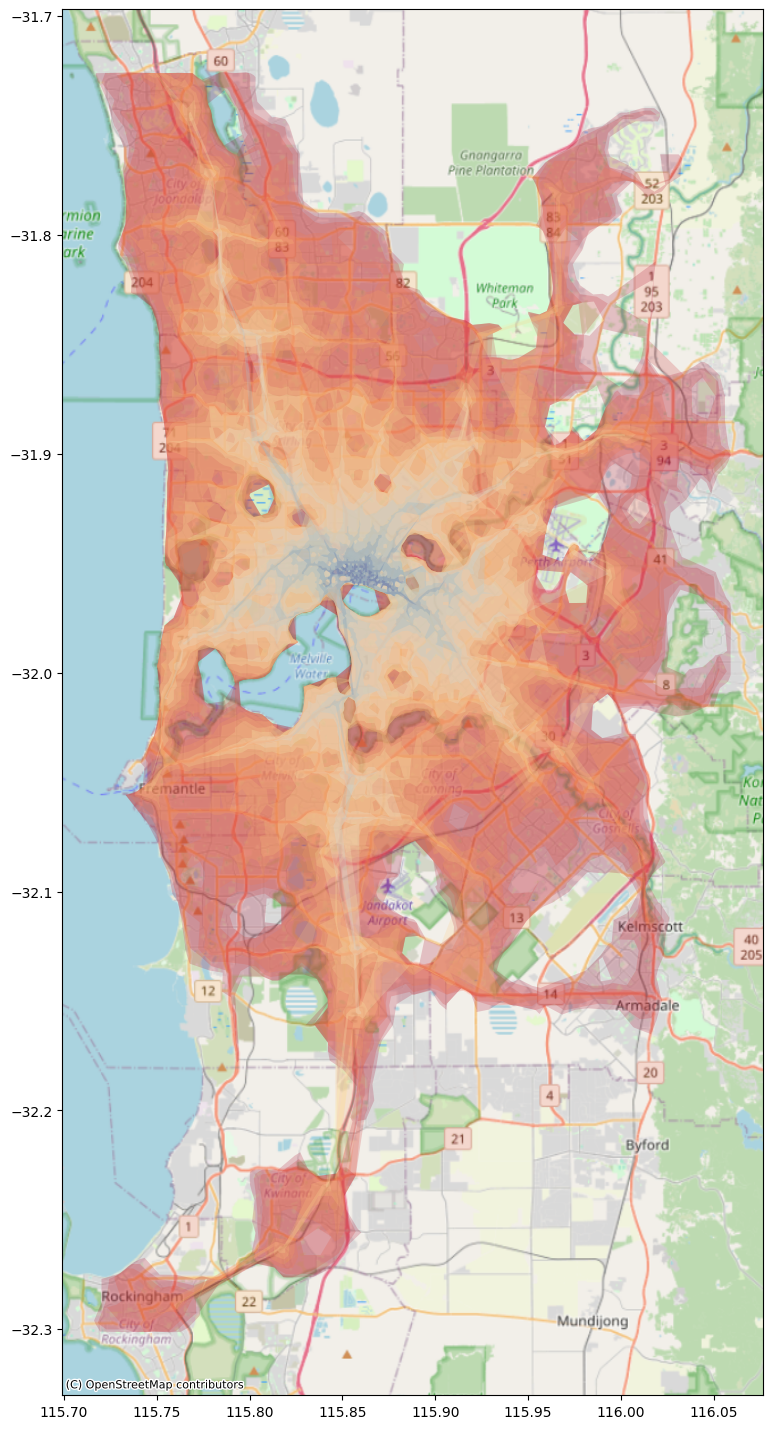

In [73]:
ax = gdf[::-1].plot(alpha=0.2,cmap="RdYlBu", legend=True,figsize=(18,18))
cx.add_basemap(
    ax,
    source=cx.providers.OpenStreetMap.Mapnik,
    crs=gdf.crs.to_string())

In [71]:
gdf[::-1].to_file(filename="polys2.geojson", driver='GeoJSON')